In [1]:
import matplotlib.pyplot as plt

from matplotlib import font_manager

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
from matplotlib import cm


import numpy as np
import pandas as pd

the necessary fonts are added to the collection

In [2]:
font_manager.fontManager.addfont('/Users/arpadambrusz/Desktop/jupyter_work/fonts/Rajdhani/Rajdhani-Medium.ttf')
font_manager.fontManager.addfont('/Users/arpadambrusz/Desktop/jupyter_work/fonts/Kdam_Thmor_Pro/KdamThmorPro-Regular.ttf')
font_manager.fontManager.addfont('/Users/arpadambrusz/Desktop/jupyter_work/fonts/Canonatia.ttf')

make some aesthetic adjustments

In [3]:
plt.rcParams['font.family'] = 'Rajdhani'
plt.rcParams['font.size'] = 11.0
plt.rcParams['ytick.labelsize']  = 12.5
plt.rcParams['ytick.minor.left'] = False

will work with the previously written functions; an explanation of the functions can be found here  -> https://github.com/ambrusza/collecting-rankings-for-teams-per-round-in-python-

In [4]:
def roundAndposition(lastRoundNum):
    df = pd.DataFrame()
    # enter the value of the last round
    for num in range(1,lastRoundNum+1,1):
        rawTable = pd.read_html(f'http://ada1bank.mlsz.hu/league?evad=59&szervezet=0&verseny=25413&fordulo={num}')
        # pd.html usually returns a list of lists (we have 19 now) - it is important to find out which one we need - we found out beforehand, in our case, number 5 is the winner
        df2 = rawTable[5][rawTable[5].columns[2:11]]
        
        df = pd.concat([df,df2])
    
    # mark the ranking with a new column
    df = (df
        .assign(Position = df.index+1))
    
    # define and sort necessary columns
    new_col = ['team','round','win','draw','lost','goalfor','goalagainst','goaldiff','point','position']
    df = (df
        .rename(columns={k:v for k,v in zip(df.columns,new_col)}))
    
    df.reset_index(drop=True)
    
    df = (df
     .assign(team = [' '.join(x.split()) for x in df.team]))
    
    return df

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------
#team position in a given round     
def posTeam(team,round_):
    return df[(df.team == team) & (df['round'] == round_) ]

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------
#function to get the positions of all the turns 
def teamPerRound(team, lastRound):
    
    pos = []
    
    for num in range(1, lastRound+1):
        posI = posTeam(team,num).position.values[0]
        pos.append(posI)
    
    
    return pd.DataFrame({'team':[f'{team}' for x in range(lastRound)], 'round':[x for x in range(1,lastRound+1)],'position':pos})

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# we write a function to extract the data we are interested in

#              -  team positions per round
#              - different metrics - max Position, min Position, standard Deviation, maxPos and minPos difference


def dataSorting(dataFrame, roundNumber):
    teamsPosPerRound = {}
    teamsNumbersAnalys = {}
    
    # position of teams per round
    for pT in range(len(dataFrame.team.unique())):
        tem = dataFrame.team.unique()[pT]
        teamsPosPerRound[tem] = teamPerRound(tem,roundNumber).position.values
        
    # interesting metrics of teams
    for sT in teamsPosPerRound:
        teamsNumbersAnalys[sT] =[teamsPosPerRound[sT].max(), teamsPosPerRound[sT].min(), \
                    teamsPosPerRound[sT].max()-teamsPosPerRound[sT].min(), teamsPosPerRound[sT].std(), teamsPosPerRound[sT][-1],teamsPosPerRound[sT].mean()]
    
    
    teamPos, teamMetr = teamsPosPerRound, teamsNumbersAnalys
    
    d2 = pd.DataFrame({'team':teamPos.keys(),'currPos':[x[-2] for x in teamMetr.values()],'bestPos':[x[1] for x in teamMetr.values()], 'worstPos':[x[0] for x in teamMetr.values()],\
                       'swingPos': [x[2] for x in teamMetr.values()],'meanPos':[round(x[-1],2) for x in teamMetr.values()],\
                       'stdPos':[round(x[3],2) for x in teamMetr.values()]}).sort_values(by='currPos').reset_index(drop=True)
    
    
    #make a MATRIX - to create the plot
    
    fgyűjt = np.zeros([20,20])
    first = []
    for e, x in enumerate(d2.team):
        for m in teamPos[x]:
            fgyűjt[e,m-1] +=1
    
    df_Matrix = pd.DataFrame(fgyűjt, index=[x for x in d2.team], columns=[x for x in range(1,21)])
    
    return df_Matrix

In [8]:
df = roundAndposition(19)

this is what came out of it

In [9]:
df

,team,round,win,draw,lost,goalfor,goalagainst,goaldiff,point,position
0,GYIRMÓT FC GYŐR,1,1,0,0,4,0,4,3,1
1,FC AJKA,1,1,0,0,3,0,3,3,2
2,SOROKSÁR SC,1,1,0,0,3,1,2,3,3
3,KOLORCITY KAZINCBARCIKA SC,1,1,0,0,2,0,2,3,4
4,MTK BUDAPEST,1,1,0,0,2,1,1,3,5
...,...,...,...,...,...,...,...,...,...,...
15,SZENTLŐRINC,19,5,6,8,26,30,-4,21,16
16,KOLORCITY KAZINCBARCIKA SC,19,5,6,8,23,33,-10,21,17
17,HR-RENT KOZÁRMISLENY,19,5,3,11,26,37,-11,18,18
18,BÉKÉSCSABA 1912 ELŐRE,19,4,5,10,26,33,-7,17,19


the matching of the name is always questionable, let's write a suitable function for it

In [10]:
def teamNameChange(dataFrame):
    
    # important adjustments, that our matrix is will fitted
    dataFrame['team'] = dataFrame.index
    dataFrame['pos'] = 0
    dataFrame = dataFrame[['pos','team',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]].reset_index(drop=True)
    
    # arbitrary names - let's pay attention to the order
    teamsName = ['Diósgyőr','Pécsi MFC','MTK','Szeged','Gyirmót','Haladás','Ajka','Csákvár','Soroksár','MTE 1904','ETO FC Győr','Tiszakécske','Siófok','Nyíregyháza','Budafoki MTE','Szentlőrinc','Kazincbarcika',
            'Kozármisleny','Békéscsaba','Dorog']
    
    df_Name = pd.DataFrame({'old':list(dataFrame.index),'new':teamsName})
    
    tt = [df_Name[df_Name.old == x].new.values[0] for x in dataFrame.index] 
    
    dataFrame = (dataFrame
        .assign(team = tt))
    
    # arranged in the correct order 
    return dataFrame.sort_index(ascending=False)

let's create our matrix

In [12]:
df_Matrix = dataSorting(df,19)

In [13]:
df_Matrix

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
DVTK,5.0,4.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
PMFC,5.0,6.0,4.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MTK BUDAPEST,7.0,1.0,6.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SZEGED-CSANÁD GROSICS AKADÉMIA,0.0,0.0,2.0,5.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
GYIRMÓT FC GYŐR,2.0,2.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SZOMBATHELYI HALADÁS,0.0,0.0,0.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
FC AJKA,0.0,1.0,0.0,0.0,1.0,1.0,4.0,1.0,5.0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
AQVITAL FC CSÁKVÁR,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,0.0,3.0,0.0,1.0,1.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0
SOROKSÁR SC,0.0,2.0,1.0,0.0,1.0,4.0,6.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CREDOBUS MOSONMAGYARÓVÁR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,3.0,2.0,4.0,0.0


arrange and clean

In [15]:
df_done = teamNameChange(df_Matrix)

In [16]:
df_done

,pos,team,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
19,0,Dorog,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,12.0
18,0,Békéscsaba,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,2.0,0.0,1.0,0.0,0.0,5.0,4.0,1.0
17,0,Kozármisleny,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,4.0,5.0,4.0,2.0,1.0
16,0,Kazincbarcika,0.0,3.0,1.0,2.0,1.0,2.0,0.0,0.0,...,1.0,1.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0
15,0,Szentlőrinc,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,3.0,2.0,1.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0
14,0,Budafoki MTE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,1.0,4.0,4.0,4.0,4.0
13,0,Nyíregyháza,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,2.0,1.0,4.0,3.0,3.0,2.0,0.0,2.0,0.0
12,0,Siófok,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,...,3.0,2.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
11,0,Tiszakécske,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,3.0,2.0,4.0,0.0,1.0,0.0,0.0,0.0
10,0,ETO FC Győr,0.0,0.0,0.0,1.0,1.0,2.0,1.0,4.0,...,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


write the function needed for the plot - details in it

In [17]:
def plot(dataFrame, number):
    
    fig = plt.figure(figsize=(14.5, 10),dpi=200)
    ax = plt.subplot(111)
    
    #we make some aesthetic adjustments that we like
    backboard = '#fefdff'

    fig.set_facecolor(backboard)
    ax.patch.set_facecolor(backboard)

    #we define and fix the fonts - if you want to change something, just rewrite it here
    signature = 'Canonatia'
    main_font = 'Kdam Thmor Pro'
    
    
    # making the matrix - rows, columns
    ncols = 22     #number of columns(cunning thing - listen!)
    nrows = dataFrame.shape[0]

    ax.set_xlim(-0.65, ncols - 0.5)
    ax.set_ylim(-0.65, nrows + 1.3)

    # define colors
    colors = ['#ffffff','#f2f0f3','#efd7b4','#e03731']
    color_cm = LinearSegmentedColormap.from_list("COLOR", colors, N=100)
    cm.register_cmap(name="COLOR", cmap=color_cm)
    cmap = cm.get_cmap("COLOR")


    for x in range(0, ncols):

        for y in range(0, nrows):

            label_ = dataFrame.iloc[y, x]
            offset_x = -0.1
            color = "black"
            color_2 = "white"
            weight = "normal"
            # -- Team name
            if x == 0:
            
                continue

            elif x == 1:
                text = label_
                ha = "left"

            elif x <22:
                if label_ == 0.00:
                    text = '-'
                else:
                    text = f'{int(label_)}'
                    color = "gray"
                offset_x = 1.1
                ha = "center"
                if label_ > 0:
                    color = "white"
                    color_2 = "black"
                ax.fill_between(
                    x = [(x - 1) + offset_x/2, (x - 1) + offset_x + offset_x/2],
                    y1 = y -.5,
                    y2 = y + .5,
                    color = cmap(label_*.129),
                    zorder = 2,
                    ec = "None"
                )
            else:
                text = f"{label_:.0f}"
                offset_x = 1.1
                ha = "center"
                weight = "bold"

            if x == 1:
                text_ = ax.annotate(
                    xy = ((x-1.5 ) + offset_x, y),
                    text = text,
                    va = "center",
                    ha = ha,
                    color = color,
                    weight = weight
                )
            else:
                text_ = ax.annotate(
                    xy = ((x - 1) + offset_x, y),
                    text = text,
                    va = "center",
                    ha = ha,
                    color = color,
                    weight = weight
                )
                text_.set_path_effects(
                    [path_effects.Stroke(linewidth=1.25, foreground=color_2), path_effects.Normal()]
                )

    # -- Set axis off
    ax.set_axis_off()
    # Table borders
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows - .5, nrows - .5], lw = 1.5, color = "black", marker = "", zorder = 4)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-.5, -.5], lw = 1.5, color = "black", marker = "", zorder = 4)
    ax.plot([5.1 - .55, 17.1 + .55], [nrows + .95, nrows + .95], lw = 1.5, color = "black", marker = "", zorder = 4)

    for x in range(nrows):
        if x == 0:
            continue
        ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x - .5, x - .5], lw = 1, color = "lightgrey", ls = ":", zorder = 3 , marker = "")

    for x in range(nrows):
        if x == 0:
            continue
        ax.plot([1.1+x - .55, 1.1+x - .55], [nrows - .5, - .5], lw = 1, color = "lightgrey", ls = ":", marker = "", zorder = 3)

    # - Column titles
    ax.annotate(
        xy = (-0.5, nrows),
        text = "TEAM NAME",
        weight = "bold",
        ha = "left",
        size = 13
    )

    for pok in range(1,21):
        ax.annotate(
            xy = (pok+1.1, nrows),
            text = f"{pok}",
            weight = "bold",
            ha = "center",
            size = 12
        )

    ax.annotate(
        xy = (11.25, nrows + 1.19),
        text = "POSITION",
        weight = "bold",
        ha = "center",
        size = 12)


    # important messages
    ax.text(-0.7,21.5,"Data provided by mlsz.adatbank - ambrusz" , fontfamily=signature, size= 40)
    ax.text(18,21.5,f"Hungary NB2. ({number}. rounds)" , fontfamily=main_font, fontweight='light', size= 10, color = 'gray')


    #plt.savefig(f'/Users/arpadambrusz/Desktop/randomWalkNb2_19forduló.png', dpi=300, bbox_inches="tight");

check it!!

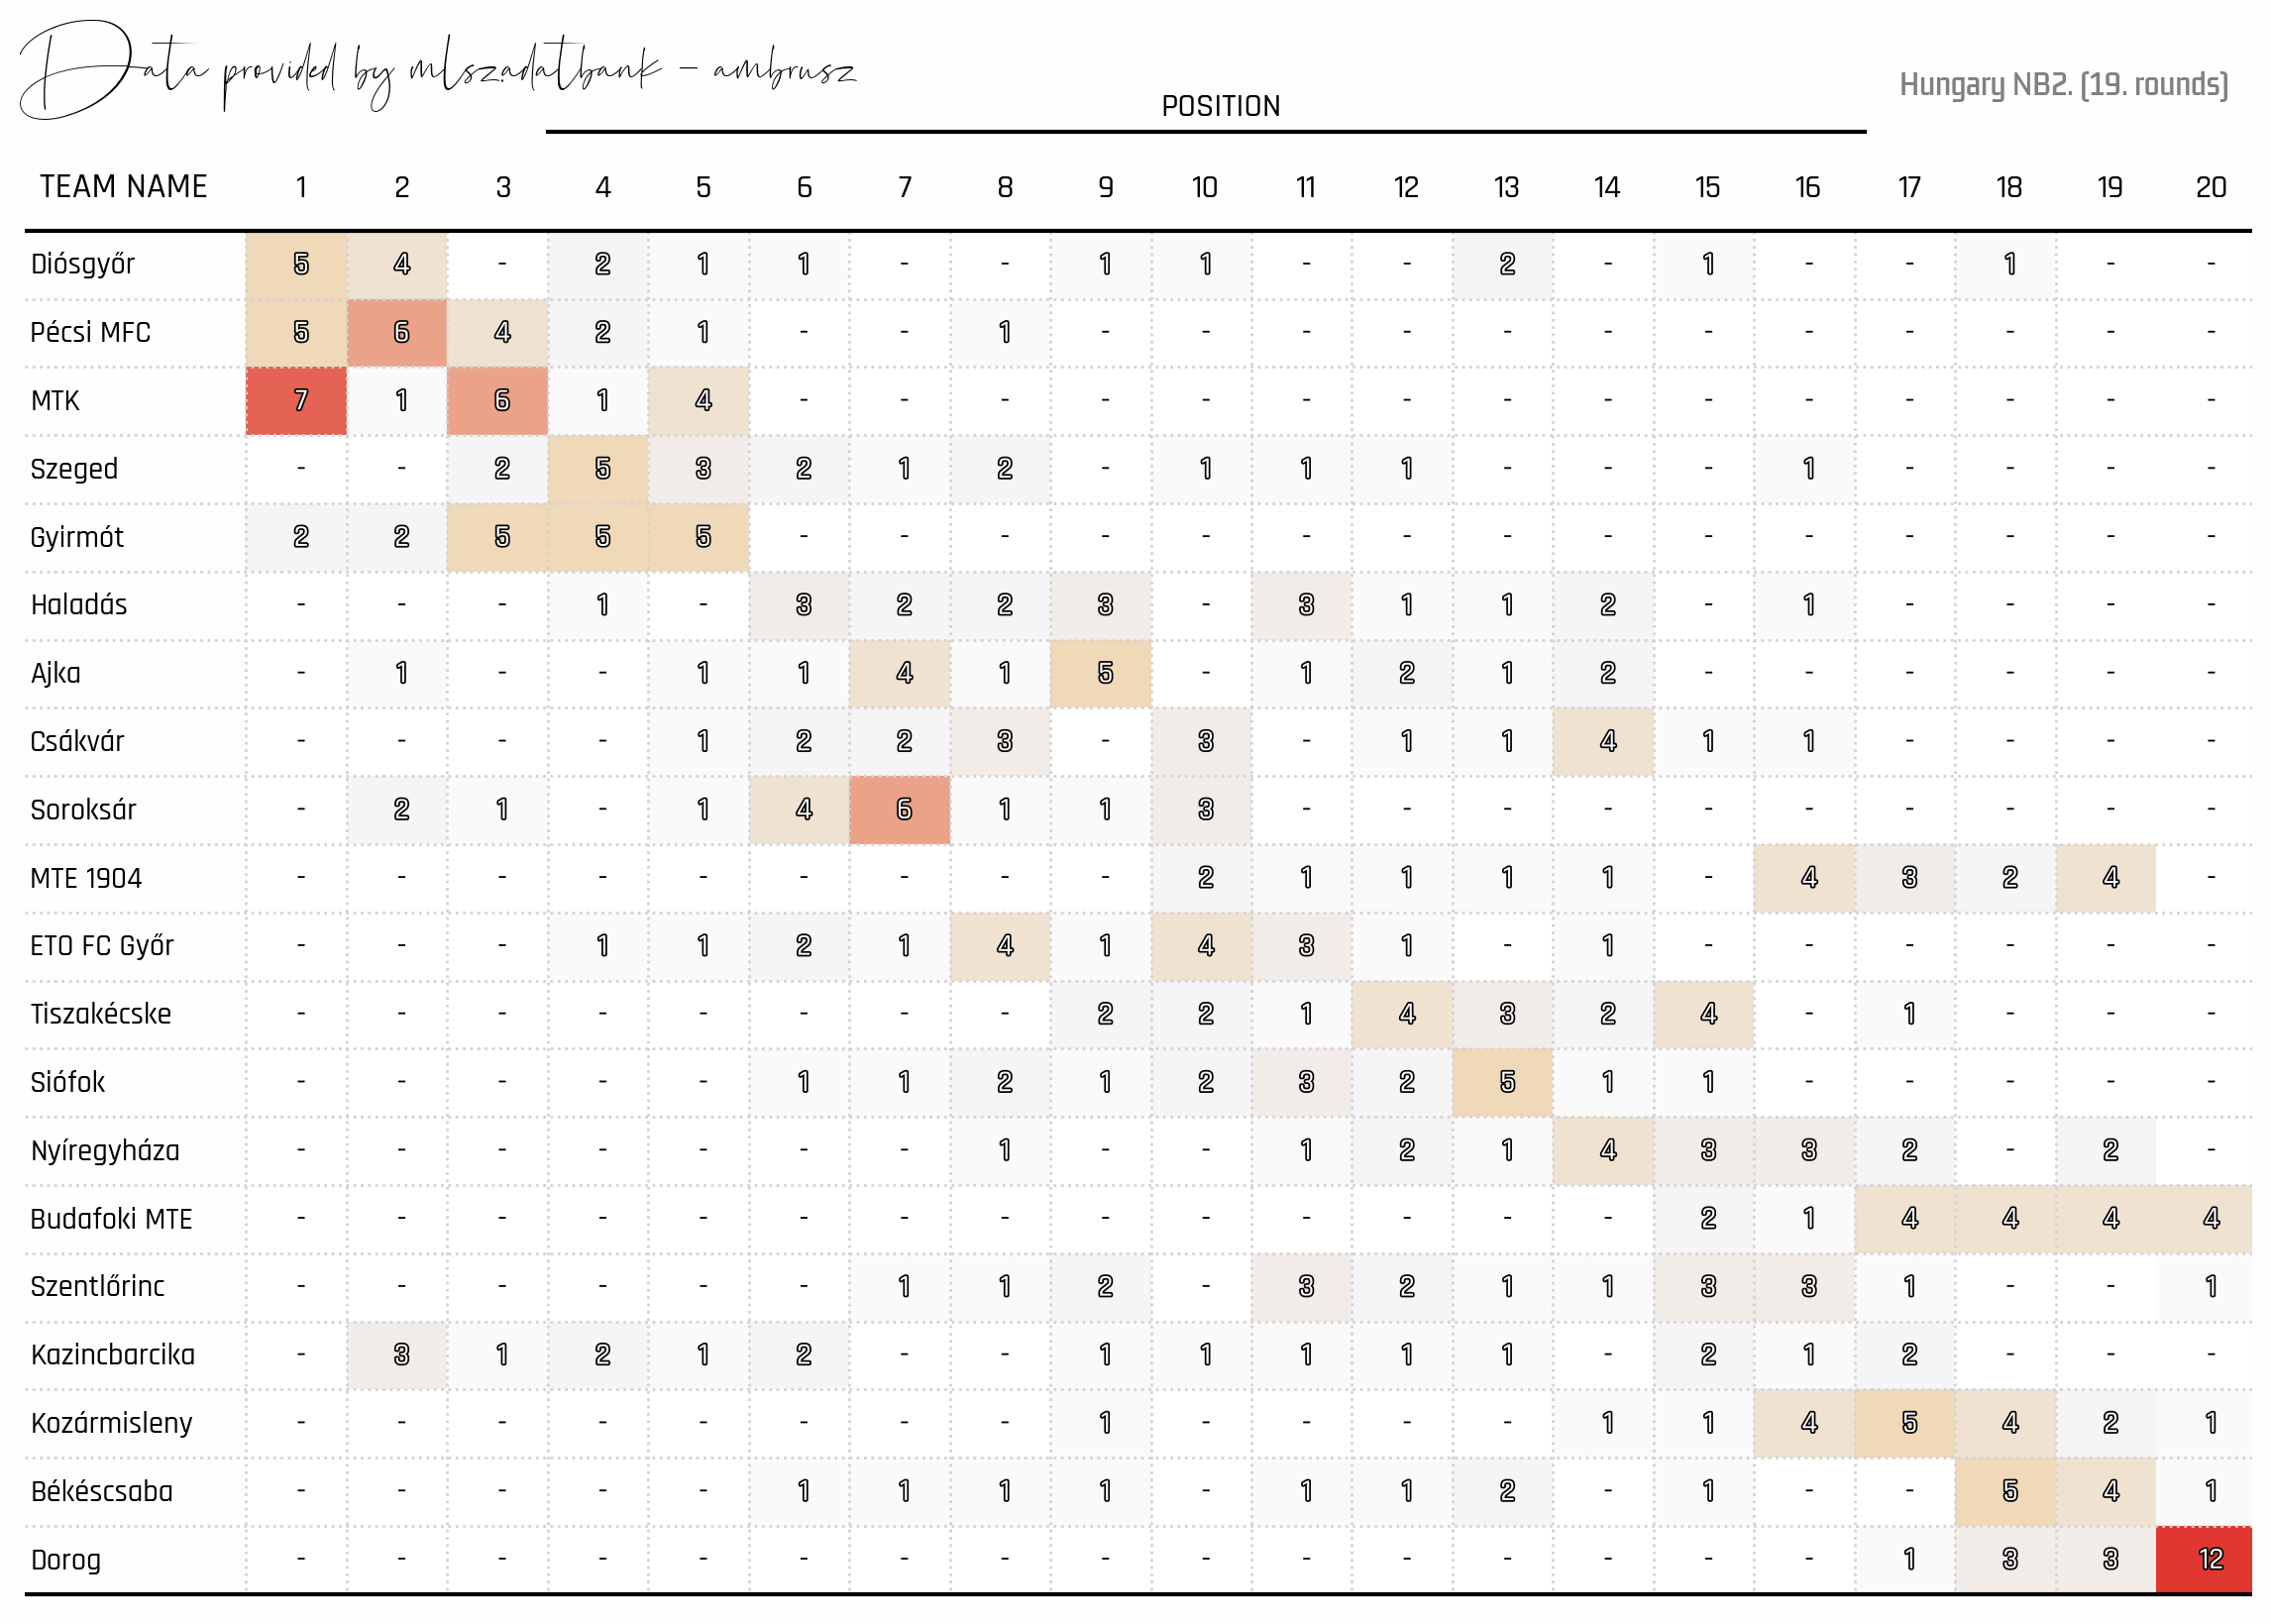

In [18]:
plot(df_done,19)